In [3]:
import pandas as pd
from pathlib import Path
from collections import Counter

def validate_and_save_citibike_data(
    input_dir: str = "C:/Users/MD/Desktop/citi/data/processed/monthly",
    output_dir: str = "C:/Users/MD/Desktop/citi/data/processed/validated"
):
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    station_counter = Counter()

    print("🔍 Scanning all files to find top 5 busiest start_station_ids...")

    for parquet_file in sorted(input_path.glob("rides_20*.parquet")):
        try:
            df = pd.read_parquet(parquet_file, columns=["start_station_id"])
            station_counter.update(df["start_station_id"].dropna().tolist())
        except Exception as e:
            print(f"⚠️ Skipped {parquet_file.name}: {e}")

    if not station_counter:
        print("🚫 No valid data found to compute top stations!")
        return

    top5_station_ids = [station_id for station_id, _ in station_counter.most_common(5)]
    print(f"✅ Top 5 Station IDs: {top5_station_ids}")

    for parquet_file in sorted(input_path.glob("rides_20*.parquet")):
        print(f"\n🔄 Processing: {parquet_file.name}")

        try:
            # Read only important columns first to filter down
            important_cols = [
                "start_station_id", "start_station_name", "start_lat", "start_lng",
                "end_station_id", "end_station_name", "end_lat", "end_lng",
                "started_at", "ended_at"
            ]
            df = pd.read_parquet(parquet_file, columns=important_cols)
        except Exception as e:
            print(f"⚠️ Failed to read {parquet_file.name}: {e}")
            continue

        # Small dataframe after reading only necessary columns
        df = df[df["start_station_id"].isin(top5_station_ids)]

        if df.empty:
            print(f"🚫 No top 5 stations found in {parquet_file.name}")
            continue

        for col in ("started_at", "ended_at"):
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")
                df[col] = (
                    df[col]
                    .dt.tz_localize("UTC", ambiguous="NaT", nonexistent="NaT")
                    .dt.tz_convert("America/New_York")
                )

        if {"started_at", "ended_at"}.issubset(df.columns):
            df["duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60.0

        if "duration_min" in df.columns:
            df = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 240)]

        drop_cols = ["start_station_id", "end_station_id", "end_lat", "end_lng"]
        if set(drop_cols).issubset(df.columns):
            df = df.dropna(subset=drop_cols)

        if {"start_lat", "start_lng"}.issubset(df.columns):
            df = df[
                df["start_lat"].between(40.4774, 40.9176)
              & df["start_lng"].between(-74.2591, -73.7004)
            ]

        if "started_at" in df.columns:
            df = df.sort_values("started_at")

        output_file = output_path / parquet_file.name
        df.to_parquet(output_file, index=False)
        print(f"✅ Cleaned and saved: {output_file} ({len(df)} rows after filtering)")

if __name__ == "__main__":
    validate_and_save_citibike_data()


🔍 Scanning all files to find top 5 busiest start_station_ids...
✅ Top 5 Station IDs: ['6140.05', '5905.14', '6450.05', '5788.13', '5329.03']

🔄 Processing: rides_2024_01.parquet
✅ Cleaned and saved: C:\Users\MD\Desktop\citi\data\processed\validated\rides_2024_01.parquet (29821 rows after filtering)

🔄 Processing: rides_2024_02.parquet
✅ Cleaned and saved: C:\Users\MD\Desktop\citi\data\processed\validated\rides_2024_02.parquet (35400 rows after filtering)

🔄 Processing: rides_2024_03.parquet
✅ Cleaned and saved: C:\Users\MD\Desktop\citi\data\processed\validated\rides_2024_03.parquet (42393 rows after filtering)

🔄 Processing: rides_2024_04.parquet
✅ Cleaned and saved: C:\Users\MD\Desktop\citi\data\processed\validated\rides_2024_04.parquet (55004 rows after filtering)

🔄 Processing: rides_2024_05.parquet
✅ Cleaned and saved: C:\Users\MD\Desktop\citi\data\processed\validated\rides_2024_05.parquet (67782 rows after filtering)

🔄 Processing: rides_2024_06.parquet
✅ Cleaned and saved: C:\Use

<Figure size 1500x600 with 0 Axes>

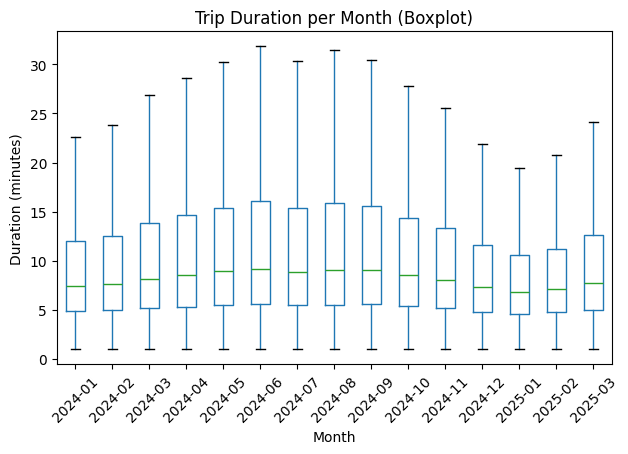

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_duration_boxplots(validated_dir="../data/processed/validated"):
    validated_path = Path(validated_dir)
    all_data = []

    # Load each validated file and extract month + duration
    for file in sorted(validated_path.glob("rides_*.parquet")):
        try:
            df = pd.read_parquet(file)
            month = file.stem.split("_")[1] + "-" + file.stem.split("_")[2]  # e.g., '2024-01'
            df["month"] = month
            all_data.append(df[["duration_min", "month"]])
        except Exception as e:
            print(f"⚠️ Skipping {file.name}: {e}")

    # Combine and sort
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df["month"] = pd.Categorical(combined_df["month"], ordered=True, categories=sorted(combined_df["month"].unique()))

    # Plot
    plt.figure(figsize=(15, 6))
    ax = combined_df.boxplot(column="duration_min", by="month", grid=False, showfliers=False)
    plt.title("Trip Duration per Month (Boxplot)")
    plt.suptitle("")  # Suppress auto title
    plt.xlabel("Month")
    plt.ylabel("Duration (minutes)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run it
plot_duration_boxplots()


<Figure size 1200x600 with 0 Axes>

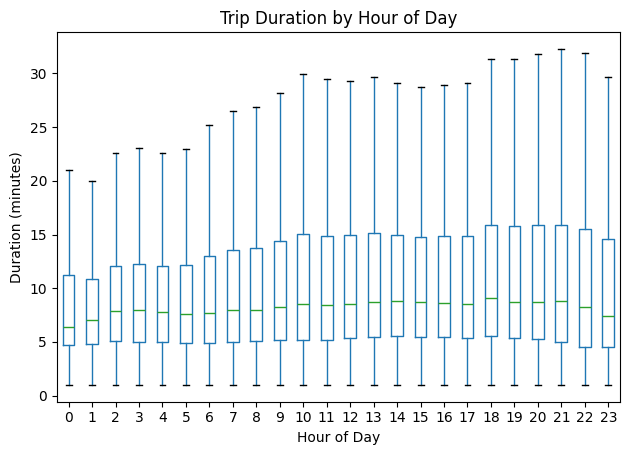

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_duration_by_hour(validated_dir="../data/processed/validated"):
    validated_path = Path(validated_dir)
    all_data = []

    for file in validated_path.glob("rides_*.parquet"):
        try:
            df = pd.read_parquet(file)
            df["hour"] = df["started_at"].dt.hour
            all_data.append(df[["duration_min", "hour"]])
        except Exception as e:
            print(f"⚠️ Skipping {file.name}: {e}")

    combined_df = pd.concat(all_data, ignore_index=True)

    # Plot
    plt.figure(figsize=(12, 6))
    combined_df.boxplot(column="duration_min", by="hour", showfliers=False, grid=False)
    plt.title("Trip Duration by Hour of Day")
    plt.suptitle("")
    plt.xlabel("Hour of Day")
    plt.ylabel("Duration (minutes)")
    plt.xticks(range(1, 25))
    plt.tight_layout()
    plt.show()

# Run it
plot_duration_by_hour()


<Figure size 1400x600 with 0 Axes>

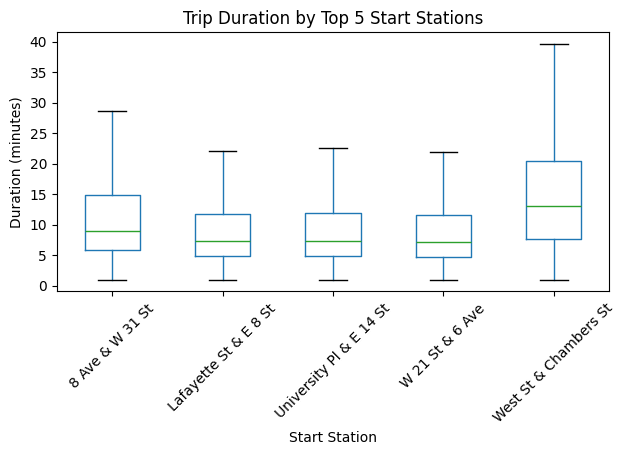

In [11]:
def plot_duration_by_top_stations(validated_dir="../data/processed/validated", top_n=5):
    validated_path = Path(validated_dir)
    all_data = []

    for file in validated_path.glob("rides_*.parquet"):
        try:
            df = pd.read_parquet(file)
            all_data.append(df[["duration_min", "start_station_name"]])
        except Exception as e:
            print(f"⚠️ Skipping {file.name}: {e}")

    df_all = pd.concat(all_data, ignore_index=True)

    # Find top N stations by count
    top_stations = df_all["start_station_name"].value_counts().head(top_n).index.tolist()
    df_top = df_all[df_all["start_station_name"].isin(top_stations)]

    # Plot
    plt.figure(figsize=(14, 6))
    df_top.boxplot(column="duration_min", by="start_station_name", showfliers=False, grid=False)
    plt.title(f"Trip Duration by Top {top_n} Start Stations")
    plt.suptitle("")
    plt.xlabel("Start Station")
    plt.ylabel("Duration (minutes)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run it
plot_duration_by_top_stations()


🏆 Top 3 Start Stations: ['W 21 St & 6 Ave', 'University Pl & E 14 St', '8 Ave & W 31 St']


<Figure size 1000x600 with 0 Axes>

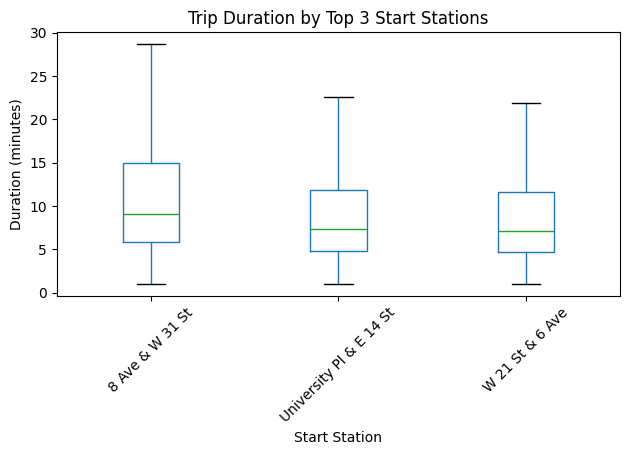

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_duration_by_top3_stations(validated_dir="../data/processed/validated"):
    validated_path = Path(validated_dir)
    all_data = []

    # Step 1: Load all data with station and duration
    for file in validated_path.glob("rides_*.parquet"):
        try:
            df = pd.read_parquet(file)
            all_data.append(df[["duration_min", "start_station_name"]])
        except Exception as e:
            print(f"⚠️ Skipping {file.name}: {e}")

    df_all = pd.concat(all_data, ignore_index=True)

    # Step 2: Identify top 3 stations by trip count
    top_3_stations = df_all["start_station_name"].value_counts().nlargest(3).index.tolist()
    print("🏆 Top 3 Start Stations:", top_3_stations)

    # Step 3: Filter and plot boxplot
    df_top = df_all[df_all["start_station_name"].isin(top_3_stations)]

    plt.figure(figsize=(10, 6))
    df_top.boxplot(column="duration_min", by="start_station_name", showfliers=False, grid=False)
    plt.title("Trip Duration by Top 3 Start Stations")
    plt.suptitle("")
    plt.xlabel("Start Station")
    plt.ylabel("Duration (minutes)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run the function
plot_duration_by_top3_stations()
